

#  **E-Waste Image Classification Using EfficientNetV2B0**



##  Problem Statement and Description

E-waste (electronic waste) is rapidly becoming a serious environmental and health issue around the world. Proper sorting and categorization of e-waste is essential for efficient recycling and disposal, but manual classification is error-prone and labor-intensive.

This project aims to build an automated e-waste classification system using artificial intelligence and machine learning. By training a deep learning model on images of different types of e-waste, we can identify and categorize them accurately.

###  Goal:
Use image classification with EfficientNetV2B0 to classify e-waste into 10 distinct categories to support better sorting and recycling automation.




In [ ]:
import zipfile
import os

zip_path = "/content/data.zip"         # path to your ZIP file
extract_dir = "/content/data01"          # target folder to extract

# Create the folder if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extraction complete. Files are in:", extract_dir)


✅ Extraction complete. Files are in: /content/data01


In [ ]:
# Install TensorFlow package
!pip install tensorflow

In [ ]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations



###The zipfile is extracted to data01/data directory and test data,train data and validation data are stored in testpath,trainpath, and validpath respectively

In [ ]:
testpath= r'/content/data01/data/test'
trainpath= r'/content/data01/data/train'
validpath = r'/content/data01/data/val'

In [ ]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [ ]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [ ]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [ ]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


##An example data from each class is displayed below

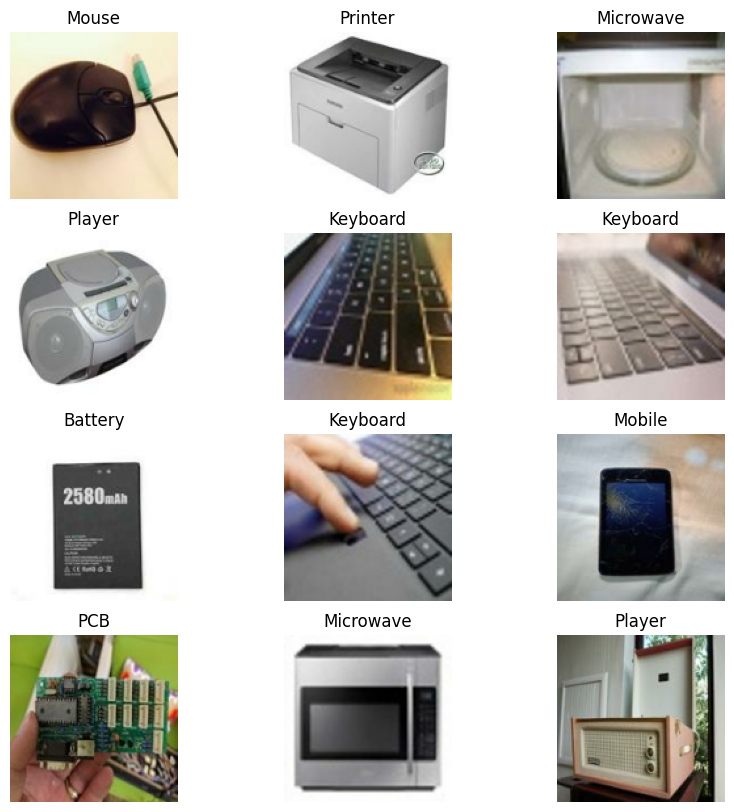

In [ ]:

# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")


##The plot_class_distribution function aims to display the data distribution over each class

In [ ]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class
    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot


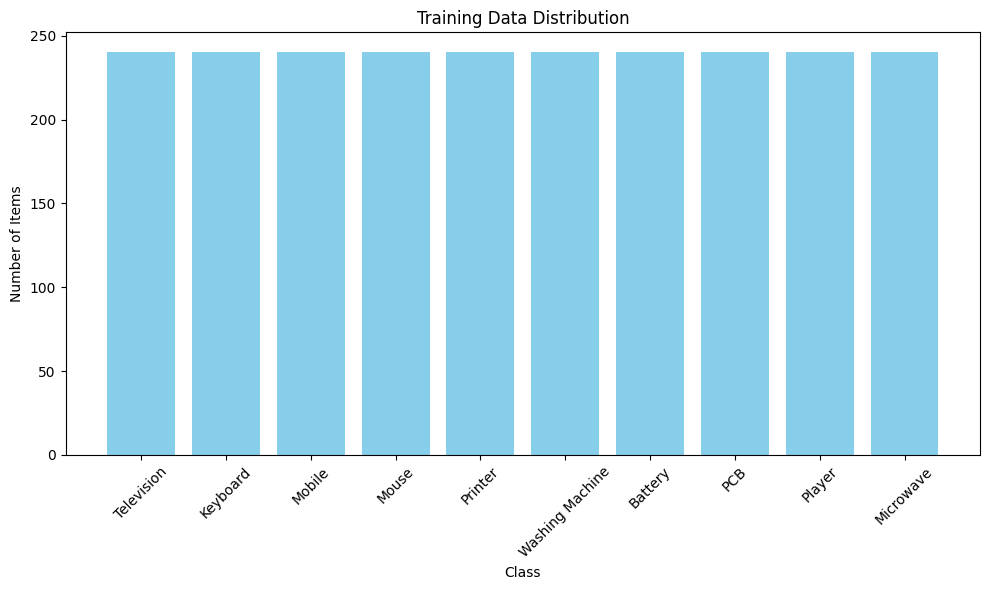

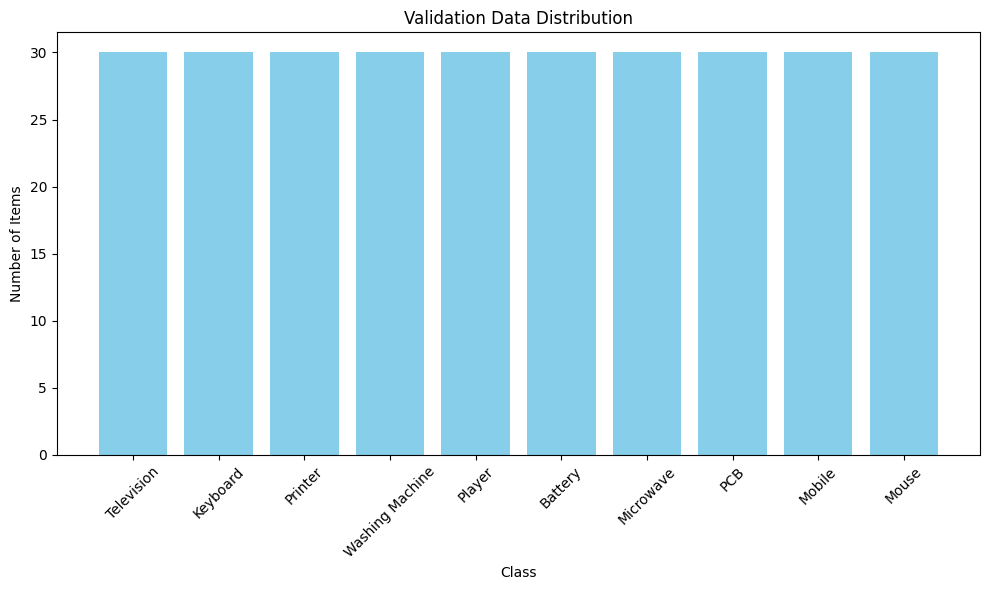

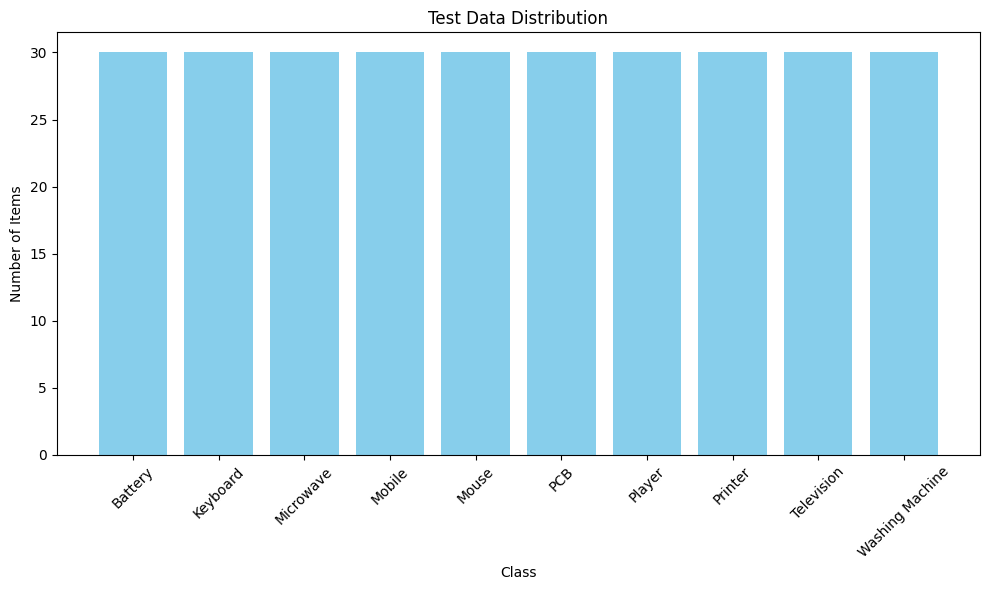

In [ ]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])


In [ ]:
"""from tensorflow.keras.applications import MobileNetV2

# Re-initialize the base model with the new input size
base_model = MobileNetV2(
    input_shape=(160, 160, 3),  # <- UPDATED SIZE
    include_top=False,
    weights='imagenet'
)"""
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False
# Full model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),  # <- MATCHING INPUT
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor="val_accuracy"
)


lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    verbose=1,
    min_lr=1e-6
)

In [ ]:
import tensorflow.keras.backend as K
K.clear_session()


In [ ]:
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=30,
    callbacks=[early_stop,lr_schedule, checkpoint_cb]
)


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - accuracy: 0.1928 - loss: 2.8535 - val_accuracy: 0.6267 - val_loss: 1.3990 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.5506 - loss: 1.4551 - val_accuracy: 0.7967 - val_loss: 0.7882 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.7161 - loss: 0.9056 - val_accuracy: 0.8400 - val_loss: 0.5497 - learning_rate: 1.0000e-04
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.7552 - loss: 0.7703 - val_accuracy: 0.8633 - val_loss: 0.4445 - learning_rate: 1.0000e-04
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.8018 - loss: 0.6360 - val_accuracy: 0.8800 - val_loss: 0.3922 - learning_rate: 1.0000e-04
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8471 - loss: 0.4893 - val_accuracy: 0.8900 - val_loss: 0.3446 - learning_rate: 1.0000e-04
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.

In [ ]:
model.summary() # Print the architecture summary of the  model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,778,939 (44.93 MB)

 Trainable params: 3,855,718 (14.71 MB)

 Non-trainable params: 211,783 (827.28 KB)

 Optimizer params: 7,711,438 (29.42 MB)

In [ ]:
base_model.summary() # Print the architecture summary of the base model

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']    # Validation loss

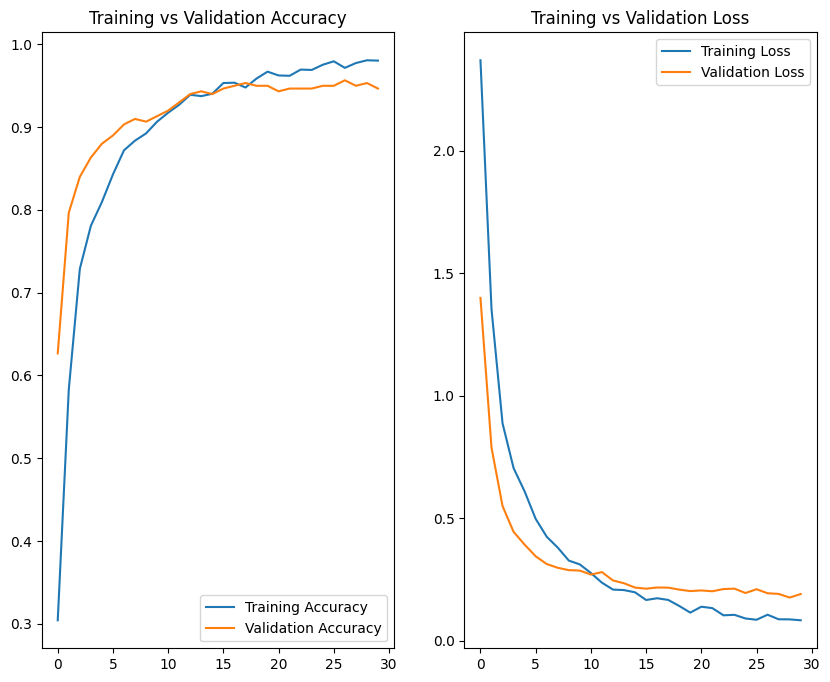

In [ ]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots


In [ ]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9257 - loss: 0.2813
Test accuracy is0.9200, Test loss is 0.2928


In [ ]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step
[[27  0  0  0  0  2  1  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 26  0  0  0  2  1  1  0]
 [ 0  0  0 29  0  1  0  0  0  0]
 [ 0  0  0  0 29  0  1  0  0  0]
 [ 0  0  0  0  0 28  2  0  0  0]
 [ 2  0  2  0  0  0 25  1  0  0]
 [ 1  0  2  0  0  0  0 27  0  0]
 [ 0  0  2  1  0  0  1  1 25  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       1.00      1.00      1.00        30
           2       0.81      0.87      0.84        30
           3       0.97      0.97      0.97        30
           4       1.00      0.97      0.98        30
           5       0.90      0.93      0.92        30
           6       0.78      0.83      0.81        30
           7       0.90      0.90      0.90        30
           8       0.96      0.83      0.89        30
           9       1.00      1.00      1.00        30

    accuracy                    

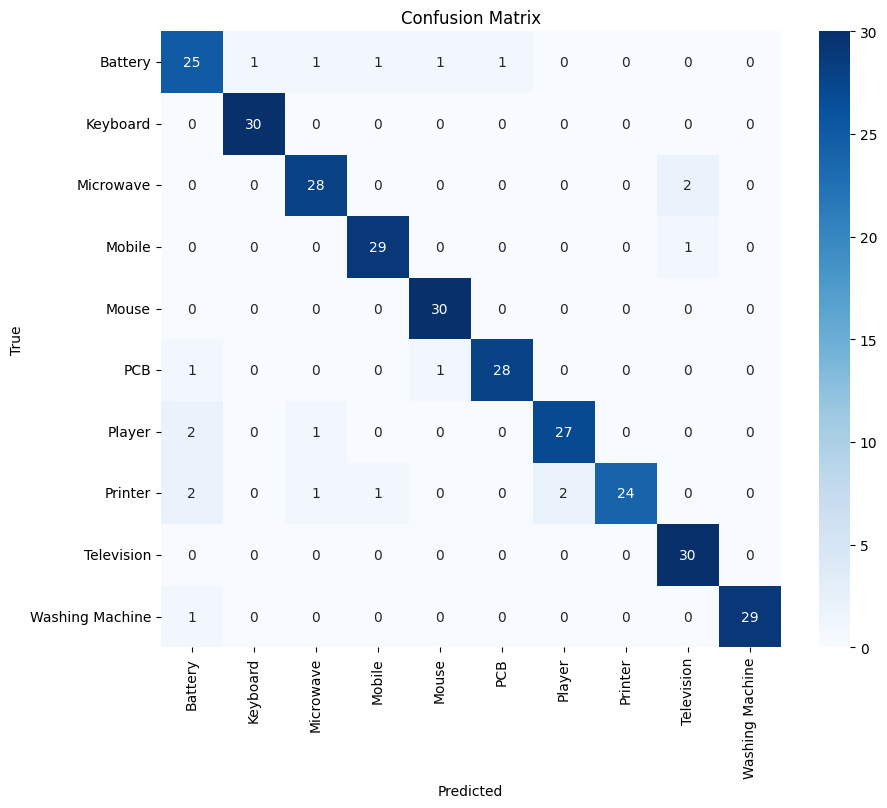

In [ ]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


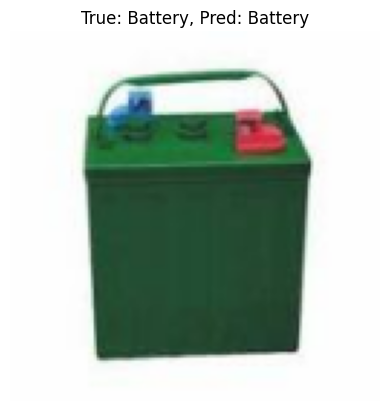

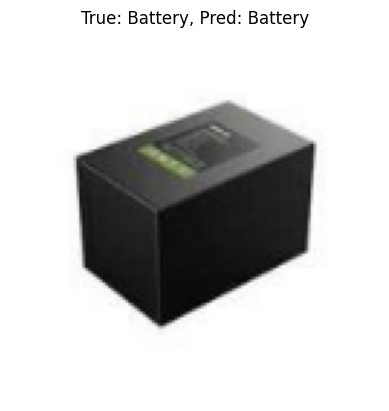

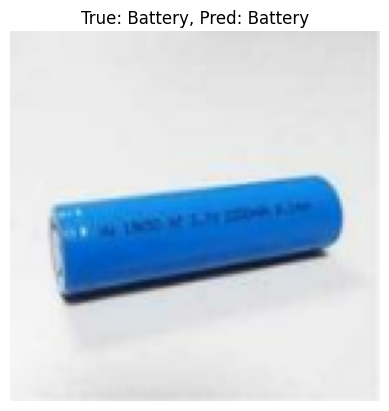

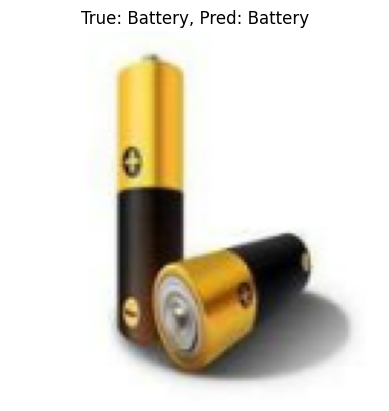

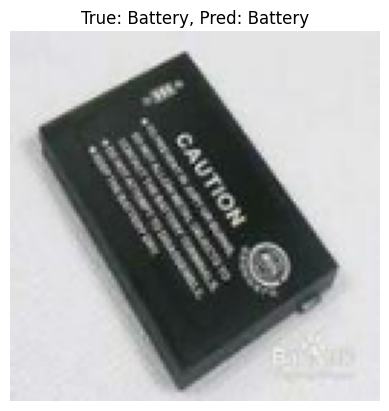

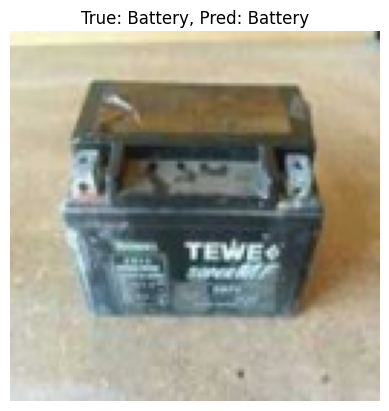

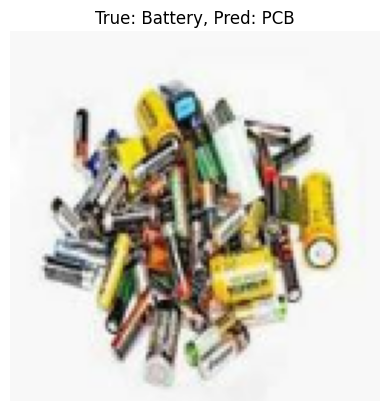

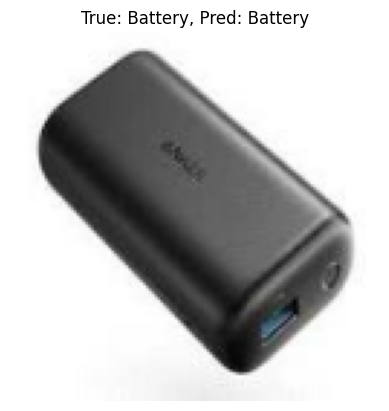

In [ ]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image



In [ ]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [ ]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')